In [1]:
import os
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'
os.chdir('/workspace/FutureGPT2/src/')


import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import transformers
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from datasets import load_dataset
from matplotlib import pyplot as plt
from itertools import islice
from copy import deepcopy

from models.myopic_model import *
from models.gpt_model import *

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger

%load_ext autoreload
%autoreload 2

In [2]:
# 5M examples sampled from the-pile. truncated to len 64
train = load_dataset(
    'EleutherAI/pile-deduped-pythia-random-sampled', 
    split='train'
)
train = train.rename_column('Tokens', 'input_ids')
train = train.remove_columns([c for c in train.column_names if c != 'input_ids'])
train = train.cast_column('input_ids', datasets.Sequence(datasets.Value('int64')))
train = train.with_format('torch')
train_loader = DataLoader(train, batch_size=32)#, num_workers=96)

In [8]:
#config = AutoConfig.from_pretrained('EleutherAI/pythia-1b')
l32 = []
l16 = []
for m in ['14m', '31m', '70m', '160m', '410m', '1b', '1.4b']:
    config = AutoConfig.from_pretrained(f'EleutherAI/pythia-{m}')
    config.upcast_attn = True
    model = AutoModelForCausalLM.from_pretrained(
        f'EleutherAI/pythia-{m}', 
        torch_dtype=torch.float32,
        config=config
    )
    model = model.to('cuda')
    torch.set_grad_enabled(False)
    x=next(iter(train_loader))['input_ids'].to('cuda')
    with torch.autocast(enabled=False, device_type='cuda'):
        out = model(input_ids=x, labels=x)
        l32.append(out.loss.item())
    with torch.autocast(enabled=True, device_type='cuda', dtype=torch.float16):
        out = model(input_ids=x, labels=x)
        l16.append(out.loss.item())
    # model.to(torch.bfloat16)
    # out = model(input_ids=x, labels=x)
    # lb16.append(out.loss.item())
    # model = AutoModelForCausalLM.from_pretrained(f'EleutherAI/pythia-{m}')
    # model = model.to('cuda')
    # model.to(torch.float16)
    # out = model(input_ids=x, labels=x)
    # l16.append(out.loss.item())

Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting att

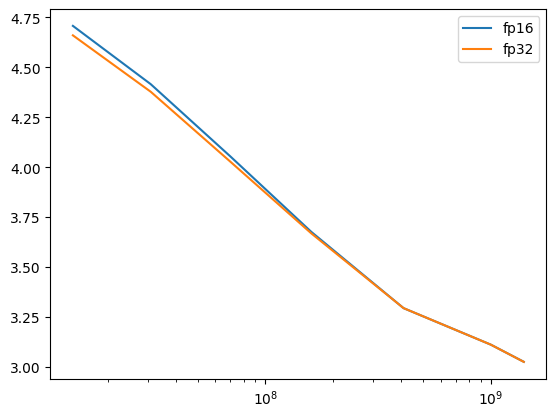

In [10]:
sizes = np.array([
    1.4e7, 3.1e7, 7.0e7, 1.6e8, 4.1e8, 1.0e9, 1.4e9
])
plt.plot(sizes, l16, label='fp16')
plt.plot(sizes, l32, label='fp32')
plt.xscale('log')
plt.legend()
plt.show()

In [7]:
model?

Signature:      model(*args, **kwargs)
Type:           GPTNeoXForCausalLM
String form:   
GPTNeoXForCausalLM(
           (gpt_neox): GPTNeoXModel(
           (embed_in): Embedding(50304, 2048)
           (emb_d <...> ntwise_affine=True)
           )
           (embed_out): Linear(in_features=2048, out_features=50304, bias=False)
           )
File:           /workspace/transformers/src/transformers/models/gpt_neox/modeling_gpt_neox.py
Docstring:     
GPTNeoX Model with a `language modeling` head on top for CLM fine-tuning.
This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) sub-class. Use
it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
behavior.

Parameters:
    config ([`~GPTNeoXConfig`]): Model configuration class with all the parameters of the model.
        Initializing with a config file does not load the weights associated with the model, only the
        configuration.

In [18]:
model.gpt_neox.layers[0].attention.query_key_value.weight[:5,:5]

tensor([[ 0.0074,  0.0006,  0.0108,  0.0151, -0.0144],
        [-0.0193,  0.0119, -0.0199,  0.0129,  0.0126],
        [-0.0120,  0.0254,  0.0165,  0.0153,  0.0258],
        [-0.0054, -0.0097, -0.0110,  0.0035, -0.0357],
        [-0.0074,  0.0032,  0.0027, -0.0124,  0.0200]], device='cuda:0',
       requires_grad=True)

In [20]:
model.bfloat16().gpt_neox.layers[0].attention.query_key_value.weight[:5,:5]

tensor([[ 0.0074,  0.0006,  0.0107,  0.0151, -0.0144],
        [-0.0193,  0.0119, -0.0199,  0.0129,  0.0126],
        [-0.0120,  0.0254,  0.0165,  0.0153,  0.0259],
        [-0.0054, -0.0097, -0.0110,  0.0035, -0.0356],
        [-0.0074,  0.0032,  0.0027, -0.0124,  0.0200]], device='cuda:0',
       dtype=torch.bfloat16, requires_grad=True)

In [104]:
model = AutoModelForCausalLM.from_pretrained(f'EleutherAI/pythia-14m').to('cuda')

In [109]:
out32 = model(input_ids=x, labels=x, output_hidden_states=True)
with torch.autocast(enabled=True, device_type='cuda', dtype=torch.float16):
    out16 = model(input_ids=x, labels=x, output_hidden_states=True)

upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!
upcasting!


In [110]:
for h16, h32 in zip(out16.hidden_states, out32.hidden_states):
    print('DIFF', (torch.norm(h16 - h32) / torch.norm(h32)).item())
    print('NORM', torch.norm(h32).item() / h32.numel()**0.5)

DIFF 0.0
NORM 0.028488444164395332
DIFF 0.0010790742235258222
NORM 0.1050114780664444
DIFF 0.002915173303335905
NORM 0.12294568866491318
DIFF 0.005754833575338125
NORM 0.30562421679496765
DIFF 0.0443398579955101
NORM 0.20599085092544556
DIFF 0.052252836525440216
NORM 0.22724969685077667
DIFF 0.011668785475194454
NORM 48.93266677856445


In [103]:
model?

Signature:      model(*args, **kwargs)
Type:           GPTNeoXForCausalLM
String form:   
GPTNeoXForCausalLM(
           (gpt_neox): GPTNeoXModel(
           (embed_in): Embedding(50304, 128)
           (emb_dr <...> entwise_affine=True)
           )
           (embed_out): Linear(in_features=128, out_features=50304, bias=False)
           )
File:           ~/.local/lib/python3.10/site-packages/transformers/models/gpt_neox/modeling_gpt_neox.py
Docstring:     
GPTNeoX Model with a `language modeling` head on top for CLM fine-tuning.
This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) sub-class. Use
it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
behavior.

Parameters:
    config ([`~GPTNeoXConfig`]): Model configuration class with all the parameters of the model.
        Initializing with a config file does not load the weights associated with the model, only the
        conf

In [79]:
h16.norm() / h16.numel()**0.5

tensor(nan, device='cuda:0')

In [80]:
h32.norm() / h32.numel()**0.5

tensor(23.7050, device='cuda:0')

In [17]:
train = load_dataset(
    'EleutherAI/pile-deduped-pythia-random-sampled', 
    split='train'
)
train = train.cast_column('Tokens', datasets.Sequence(datasets.Value('int64')))
train = train.with_format('torch')
train_loader = DataLoader(train, batch_size=32)
x=next(iter(train_loader))['Tokens'].to('cuda')

model = AutoModelForCausalLM.from_pretrained(f'EleutherAI/pythia-14m').to('cuda')
with torch.autocast(enabled=True, device_type='cuda', dtype=torch.float16):
    out = model(input_ids=x, labels=x, output_hidden_states=True)
print(out.loss.item())

nan


In [18]:
config = AutoConfig.from_pretrained('EleutherAI/pythia-14m')
config.upcast_attn = True
model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-14m', config=config).to('cuda')
with torch.autocast(enabled=True, device_type='cuda', dtype=torch.float16):
    out = model(input_ids=x, labels=x, output_hidden_states=True)
print(out.loss.item())

Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
Upcasting attention!
4.707828521728516


In [11]:
x.shape

torch.Size([64, 64])